In [ ]:
!pip install kaggle #if your dataset is availble on Kaggle


In [ ]:
from google.colab import files
files.upload()  # Upload your token API kaggle.json FILE here


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"randeepsinghklair","key":"5467def8f224e8173df154578d2c6a90"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json 

#TO create a directory in goggle collab


In [5]:
!kaggle datasets download -d grassknoted/asl-alphabet -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
 98% 1.00G/1.03G [00:05<00:00, 237MB/s]
100% 1.03G/1.03G [00:05<00:00, 192MB/s]


In [6]:
import os

data_dir = "/content/asl_alphabet_train/asl_alphabet_train"
print("Number of classes:", len(os.listdir(data_dir)))
print("First 5 classes:", os.listdir(data_dir)[:5])


Number of classes: 29
First 5 classes: ['Q', 'N', 'T', 'P', 'Z']


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [17]:
# dataset path
data_dir = "/content/asl_alphabet_train/asl_alphabet_train"

# get class labels
classes = sorted(os.listdir(data_dir))
num_classes = len(classes)
print("Classes:", num_classes)

# collect filepaths & labels
filepaths = []
labels = []

for label in classes:
    class_dir = os.path.join(data_dir, label)
    for fname in os.listdir(class_dir):
        filepaths.append(os.path.join(class_dir, fname))
        labels.append(classes.index(label))

filepaths = np.array(filepaths)
labels = np.array(labels)

print("Total samples:", len(filepaths))


Classes: 29
Total samples: 87000


In [18]:
def create_model(img_size=64, num_classes=29):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [21]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold

k = 3
img_size = 64
batch_size = 64
epochs = 5   # keep small to save runtime

kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(filepaths, labels)):
    print(f"\nFold {fold+1} / {k}")

    # split data
    train_files, val_files = filepaths[train_idx], filepaths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # datagen
    train_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        dataframe=pd.DataFrame({"filename": train_files, "class": train_labels}),
        x_col="filename",
        y_col="class",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="raw"
    )

    val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        dataframe=pd.DataFrame({"filename": val_files, "class": val_labels}),
        x_col="filename",
        y_col="class",
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="raw"
    )

    # build model
    model = create_model(img_size, num_classes)

    # train
    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=1)

    # evaluate
    loss, acc = model.evaluate(val_gen, verbose=0)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")
    fold_accuracies.append(acc)

print("\nCross Validation Results")
for i, acc in enumerate(fold_accuracies):
    print(f"Fold {i+1}: {acc:.4f}")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f}")



===== Fold 1 / 3 =====
Found 58000 validated image filenames.
Found 29000 validated image filenames.
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


907/907 ━━━━━━━━━━━━━━━━━━━━ 79s 80ms/step - accuracy: 0.3359 - loss: 2.3853 - val_accuracy: 0.7331 - val_loss: 0.8872
Epoch 2/5
907/907 ━━━━━━━━━━━━━━━━━━━━ 67s 74ms/step - accuracy: 0.8345 - loss: 0.4808 - val_accuracy: 0.9319 - val_loss: 0.2119
Epoch 3/5
907/907 ━━━━━━━━━━━━━━━━━━━━ 66s 73ms/step - accuracy: 0.9329 - loss: 0.1954 - val_accuracy: 0.8431 - val_loss: 0.6777
Epoch 4/5
907/907 ━━━━━━━━━━━━━━━━━━━━ 66s 73ms/step - accuracy: 0.9586 - loss: 0.1237 - val_accuracy: 0.9360 - val_loss: 0.2292
Epoch 5/5
907/907 ━━━━━━━━━━━━━━━━━━━━ 89s 98ms/step - accuracy: 0.9656 - loss: 0.1049 - val_accuracy: 0.9739 - val_loss: 0.0832
Fold 1 Accuracy: 0.9739

===== Fold 2 / 3 =====
Found 58000 validated image filenames.
Found 29000 validated image filenames.
Epoch 1/5
907/907 ━━━━━━━━━━━━━━━━━━━━ 80s 81ms/step - accuracy: 0.3252 - loss: 2.3695 - val_accuracy: 0.8668 - val_loss: 0.3813
Epoch 2/5
907/907 ━━━━━━━━━━━━━━━━━━━━ 73s 81ms/step - accuracy: 0.8261 - loss: 0.5067 - val_accuracy: 0.8162 

In [24]:
print("\nCross Validation Results")
for i, acc in enumerate(fold_accuracies):
    print(f"Fold {i+1}: {acc:.4f}")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f}")



Cross Validation Results
Fold 1: 0.9739
Fold 2: 0.9947
Fold 3: 0.9579
Mean Accuracy: 0.9755


Found 29000 validated image filenames.
  1/454 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


454/454 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step


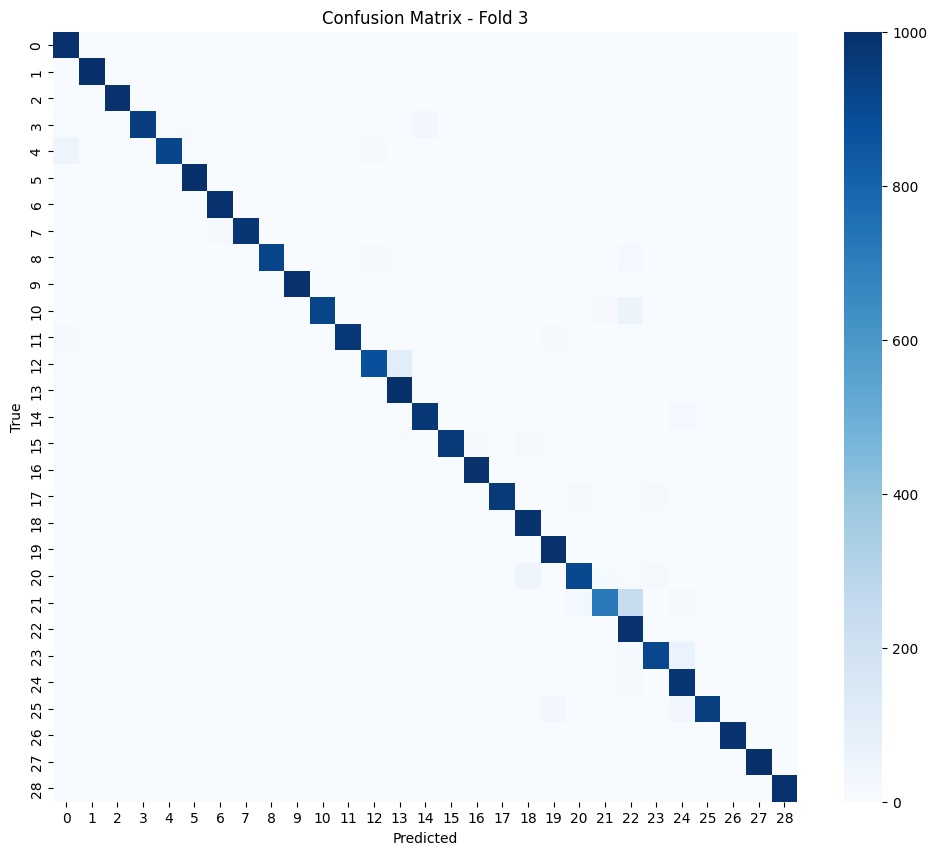

              precision    recall  f1-score   support

           A       0.92      0.99      0.95      1000
           B       0.98      1.00      0.99      1000
           C       1.00      1.00      1.00      1000
           D       1.00      0.95      0.97      1000
           E       0.98      0.92      0.95      1000
           F       0.99      1.00      0.99      1000
           G       0.98      0.99      0.99      1000
           H       1.00      0.98      0.99      1000
           I       1.00      0.92      0.96      1000
           J       0.99      0.99      0.99      1000
           K       0.99      0.92      0.96      1000
           L       1.00      0.97      0.98      1000
           M       0.95      0.88      0.91      1000
           N       0.88      1.00      0.93      1000
           O       0.97      0.97      0.97      1000
           P       1.00      0.96      0.98      1000
           Q       0.99      1.00      0.99      1000
           R       0.98    

In [29]:
val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=pd.DataFrame({"filename": val_files, "class": val_labels}),
    x_col="filename",
    y_col="class",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="raw",
    shuffle=False   # ⬅️ important!
)

# Predictions
y_true = val_gen.labels
y_pred = np.argmax(model.predict(val_gen), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title(f"Confusion Matrix - Fold {fold+1}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report (map indices back to class names)
print(classification_report(y_true, y_pred, target_names=classes))
